# Exercise VI: Revisiting Linear and Logistic Regression

In the following exercise we will follow an adapted version of [Prof. Tal Yarkoni](https://talyarkoni.org/)'s workshop in  the [NeuroHackademy](https://neurohackademy.org/) 2020 (available [here](https://github.com/neurohackademy/nh2020-curriculum/tree/master/tu-machine-learning-yarkoni)).

Our dataset includes features extracted from the [Autism Brain Imaging Data Exchange II (ABIDE II)](http://fcon_1000.projects.nitrc.org/indi/abide/abide_II.html) project using [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/) (available [here](https://github.com/rb643/Normative_modeling)) {cite}`richard2019normative`, as well as some demographic and phenotypic information about the subjects. 

To review the methods discussed in the course so far, we will try and use FreeSurfer's estimated brain features to predict age and Autistic Spectrum Disorder (ASD) diagnosis as a review for both linear and logistic regression (respectively).

## Set up

To read a `.tsv` file we have to specify `delimiter="\t"`:

In [1]:
import pandas as pd

csv_url = "https://raw.githubusercontent.com/neurohackademy/nh2020-curriculum/master/tu-machine-learning-yarkoni/data/abide2.tsv"
data = pd.read_csv(csv_url, delimiter="\t")

Never hurts to clean up a little:

In [2]:
IGNORED_COLUMNS = ["age_resid", "sex"]
REPLACE_DICT = {"group": {1: "ASD", 2: "Control"}}

data.drop(columns=IGNORED_COLUMNS, inplace=True)
data.replace(REPLACE_DICT, inplace=True)

## General Inspection

In [3]:
data

,site,subject,age,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,ABIDEII-KKI_1,29293,8.893151,ASD,2750.0,306.0,354.0,2123.0,1451.0,1128.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,ABIDEII-OHSU_1,28997,12.000000,ASD,2836.0,186.0,354.0,2261.0,1584.0,1241.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,ABIDEII-GU_1,28845,8.390000,Control,3394.0,223.0,373.0,2827.0,1816.0,1299.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,ABIDEII-NYU_1,29210,8.300000,ASD,3382.0,266.0,422.0,2686.0,1893.0,1359.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,ABIDEII-EMC_1,29894,7.772758,Control,3080.0,161.0,346.0,2105.0,1307.0,1004.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,ABIDEII-IU_1,29570,20.000000,Control,3321.0,290.0,381.0,2802.0,1827.0,1314.0,...,2.553,3.502,2.955,2.873,3.074,2.849,2.941,2.863,2.854,3.265
1000,ABIDEII-NYU_1,29233,10.862000,Control,2860.0,162.0,456.0,2460.0,1718.0,1225.0,...,2.437,3.658,2.537,2.482,3.425,2.819,3.304,2.688,3.200,3.086
1001,ABIDEII-SDSU_1,28862,11.200000,Control,3377.0,177.0,497.0,2810.0,1866.0,1343.0,...,2.770,3.422,2.925,3.028,3.285,2.717,3.073,2.899,3.029,3.292
1002,ABIDEII-KKI_1,29312,9.789041,Control,3322.0,297.0,426.0,2640.0,1726.0,1242.0,...,2.579,3.328,2.998,3.062,3.601,3.049,2.901,2.704,3.076,3.114


```{margin}
For a useful summary of cortical atlas parcellations in MNI space, including the HCP-MMP1, see [this page](https://www.lead-dbs.org/helpsupport/knowledge-base/atlasesresources/cortical-atlas-parcellations-mni-space/).
```

First thing to note is that we have 1004 observations (subjects) and 1,446 features. 

There are 1,440 features representing four anatomical brain features estimated by FreeSurfer: 
* Surface Area (`fsArea`)
* Volume (`fsVol`)
* Cortical Thickness (`fsCT`)
* [Local Gyrification Index](https://surfer.nmr.mgh.harvard.edu/fswiki/LGI) (`fsLGI`) 

over 360 brain regions of interest (ROIs) as defined by the [Human Connectome Project Multi-Modal Parcellation atlas (HCP-MMP1)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4990127/), as well as:

* `site`: A code representing the site at which the data was acquired.
* `subject`: Subject ID.
* `age`: Age in years.
* `group`: ASD diagnosis (*1=autism, 2=control*).

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Columns: 1444 entries, site to fsCT_R_p24_ROI
dtypes: float64(1441), int64(1), object(2)
memory usage: 11.1+ MB


As expected, all the brain features and the recorded `age` are of type `float`, `subject` (which will of course be dropped in our features matrix) is an `int`, and `site` and `group` are categorical (`object`).

## Feature Matrix

Our feature matrix is the same in both regression examples and composed exclusively of FreeSurfer's estimation results of the 360 HCP-MMP1 ROIs: 

In [5]:
X = data.filter(regex="^fs").copy()  # Select columns starting with "fs"
X

,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,fsArea_L_V8_ROI,fsArea_L_4_ROI,fsArea_L_3b_ROI,fsArea_L_FEF_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,2750.0,306.0,354.0,2123.0,1451.0,1128.0,269.0,1751.0,1338.0,632.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,2836.0,186.0,354.0,2261.0,1584.0,1241.0,259.0,1521.0,1105.0,302.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,3394.0,223.0,373.0,2827.0,1816.0,1299.0,221.0,1657.0,1374.0,456.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,3382.0,266.0,422.0,2686.0,1893.0,1359.0,234.0,1889.0,1545.0,407.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,3080.0,161.0,346.0,2105.0,1307.0,1004.0,254.0,1334.0,985.0,315.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,3321.0,290.0,381.0,2802.0,1827.0,1314.0,184.0,1992.0,1668.0,579.0,...,2.553,3.502,2.955,2.873,3.074,2.849,2.941,2.863,2.854,3.265
1000,2860.0,162.0,456.0,2460.0,1718.0,1225.0,240.0,2459.0,1721.0,574.0,...,2.437,3.658,2.537,2.482,3.425,2.819,3.304,2.688,3.200,3.086
1001,3377.0,177.0,497.0,2810.0,1866.0,1343.0,254.0,1758.0,1318.0,436.0,...,2.770,3.422,2.925,3.028,3.285,2.717,3.073,2.899,3.029,3.292
1002,3322.0,297.0,426.0,2640.0,1726.0,1242.0,318.0,1719.0,1310.0,444.0,...,2.579,3.328,2.998,3.062,3.601,3.049,2.901,2.704,3.076,3.114


### Scaling

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X.loc[:, :] = scaler.fit_transform(X.loc[:, :])
X

,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,fsArea_L_V8_ROI,fsArea_L_4_ROI,fsArea_L_3b_ROI,fsArea_L_FEF_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,-0.829942,1.164264,-0.617506,-1.429303,-1.262839,-0.828693,0.112244,-0.246071,-0.313098,1.956778,...,2.364904,-0.913419,0.315561,-0.580204,0.089160,0.650036,0.806525,-0.195324,-0.480189,-0.055639
1,-0.656456,-0.587979,-0.617506,-1.027515,-0.696653,-0.278204,-0.058090,-1.177284,-1.504883,-1.282974,...,0.768075,0.599082,0.842638,0.139142,1.103577,0.816385,0.614441,-0.068156,-0.346434,0.312323
2,0.469190,-0.047704,-0.334418,0.620402,0.290980,0.004348,-0.705356,-0.626653,-0.128959,0.228910,...,-0.311878,0.135985,0.384997,-0.988722,-0.077848,0.955513,0.171579,0.617309,0.205661,0.078857
3,0.444982,0.580183,0.395648,0.209878,0.618772,0.296643,-0.483923,0.312657,0.745699,-0.252144,...,2.327366,0.184844,0.053601,0.911773,0.262353,-0.106096,0.883893,0.012487,0.416254,0.160063
4,-0.164238,-0.953029,-0.736700,-1.481711,-1.875853,-1.432770,-0.143256,-1.934400,-2.118678,-1.155347,...,-0.332091,-0.673373,0.416558,-0.340422,0.794304,-0.172636,-1.084975,1.299673,0.999654,2.352611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,0.321928,0.930632,-0.215224,0.547614,0.337807,0.077421,-1.335590,0.729679,1.374839,1.436454,...,0.028856,0.520483,0.877356,0.447010,-0.306711,0.120743,-0.295293,0.530463,-0.039082,0.162601
1000,-0.608041,-0.938427,0.902225,-0.448124,-0.126210,-0.356150,-0.381723,2.620446,1.645932,1.387367,...,-0.306103,0.851874,-0.441914,-0.710456,0.778840,0.030007,0.673133,-0.012326,0.945582,-0.291643
1001,0.434896,-0.719397,1.513097,0.570906,0.503831,0.218697,-0.143256,-0.217729,-0.415397,0.032562,...,0.655459,0.350539,0.782672,0.905852,0.345857,-0.278495,0.056862,0.642123,0.458942,0.231118
1002,0.323945,1.032846,0.455245,0.075949,-0.092154,-0.273333,0.946877,-0.375631,-0.456317,0.111101,...,0.103933,0.150855,1.013071,1.006501,1.323162,0.725649,-0.402007,0.037300,0.592697,-0.220588


## Target Variables

We will create two vectors for our two target variables, `age` and `asd_diagnosis`:

In [7]:
age = data["age"].copy()
asd_diagnosis = data["group"] == "ASD"

## Train/Test Split

This time, we will put aside 104 observations which will be used as a test dataset after training the model. In addition, 9 cross-validation groups (100 observations in each) will be used to estimate the model with the best performance.

In [8]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 900

X_train, X_test, age_train, age_test, asd_diagnosis_train, asd_diagnosis_test = train_test_split(
    X, age, asd_diagnosis, train_size=TRAIN_SIZE, random_state=0)

## Predicting Age

### Model Creation

We will use `sklearn`'s [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) estimator along with the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) class to fine-tune regularization strength by comparing cross-validated models:

In [9]:
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

linear_estimator = Lasso(max_iter=1_000_000)

# Model search configuration
ALPHAS = np.logspace(start=-2, stop=0, num=50, endpoint=True)
PARAM_GRID = {"alpha": ALPHAS}
N_CROSS_VALIDATIONS = 5
SCORING = ["r2", "neg_mean_squared_error"]
SCORER = "neg_mean_squared_error"
SEARCH_CONFIGURATION = {
    "estimator": linear_estimator,
    "param_grid": PARAM_GRID,
    "scoring": SCORING,
    "refit": SCORER,
    "cv": N_CROSS_VALIDATIONS,
    "n_jobs": 8
}

# GridSearchCV instantiation
linear_model_searcher = GridSearchCV(**SEARCH_CONFIGURATION)

Finally, we are ready to fit our model:

In [10]:
_ = linear_model_searcher.fit(X_train, age_train)

### Model Application

In [11]:
predicted_ages = linear_model_searcher.predict(X_test)

### Model Evaluation

To get the parameters (of the search grid, in our case just $\alpha$ values) of the chosen model:

In [12]:
best_alpha = linear_model_searcher.best_params_["alpha"]
best_alpha

0.16768329368110074

Or, retrieve a report of each iteration over the parameter grid:

In [13]:
linear_search_results = pd.DataFrame(linear_model_searcher.cv_results_)
linear_search_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,std_test_r2,rank_test_r2,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,split3_test_neg_mean_squared_error,split4_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,173.935865,90.145001,0.045564,0.008850,0.01,{'alpha': 0.01},0.128750,0.329345,0.359496,0.246348,...,0.099318,50,-74.924877,-57.301932,-60.677574,-63.988265,-51.400820,-61.658694,7.830536,50
1,129.425434,51.864770,0.034838,0.005684,0.0109854,{'alpha': 0.010985411419875584},0.172036,0.352335,0.387878,0.273604,...,0.092533,49,-71.202365,-55.337606,-57.988845,-61.674149,-49.502788,-59.141151,7.219166,49
2,132.679657,46.675282,0.026791,0.005988,0.0120679,{'alpha': 0.012067926406393288},0.210728,0.373921,0.416886,0.299843,...,0.087236,48,-67.875037,-53.493287,-55.240771,-59.446306,-47.709083,-56.752897,6.718015,48
3,111.737489,46.893967,0.030496,0.005892,0.0132571,{'alpha': 0.013257113655901088},0.245872,0.399554,0.445159,0.326649,...,0.082776,47,-64.852720,-51.303155,-52.562419,-57.170381,-46.088355,-54.395406,6.308484,47
4,96.124928,45.034311,0.026213,0.003195,0.0145635,{'alpha': 0.014563484775012436},0.279215,0.422651,0.472324,0.351699,...,0.079817,46,-61.985343,-49.329668,-49.988940,-55.043480,-44.117027,-52.092891,6.037268,46


#### Score

To get the best score (the score of the chosen model):

In [14]:
linear_model_searcher.best_score_

-27.409222768691386

In [15]:
from myst_nb import glue

glue("scorer", SCORER, display=False)

Since we've specified `refit="`{glue:text}`scorer` `"`, the retrieved score indicates the maximal `neg_mean_squared_error`, or minimal $MSE$ of the chosen model.

Other collected scores (such as $R^2$, in our case) are available in the `cv_results_` dictionary, as demonstrated above.

##### Model Score by $\alpha$

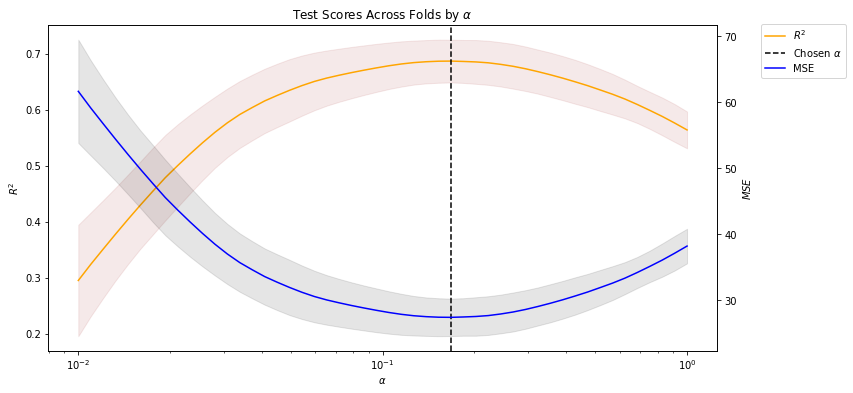

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(r"Test Scores Across Folds by $\alpha$")

#######
# R^2 #
#######

# Plot mean r2 score
ax.semilogx("param_alpha",
            "mean_test_r2",
            data=linear_search_results,
            label=r"$R^2$",
            color="orange")

# Plot r2 STD across folds
r2_mean = linear_search_results["mean_test_r2"]
r2_std = linear_search_results["std_test_r2"]
r2_lower_limit = r2_mean - r2_std
r2_upper_limit = r2_mean + r2_std
ax.fill_between(ALPHAS,
                r2_lower_limit,
                r2_upper_limit,
                color="brown",
                alpha=0.1)

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$R^2$")

#######
# MSE #
#######

# Convert negative MSE to MSE
mse_mean = -linear_search_results["mean_test_neg_mean_squared_error"]

# Created another Axis instance with a shared X-axis
mse_ax = ax.twinx()

# Plot mean MSE score
mse_ax.semilogx(ALPHAS, mse_mean, label="MSE", color="blue")

# Plot MSE STD across folds
mse_std = linear_search_results["std_test_neg_mean_squared_error"]
mse_lower_limit = mse_mean - mse_std
mse_upper_limit = mse_mean + mse_std
mse_ax.fill_between(ALPHAS,
                    mse_lower_limit,
                    mse_upper_limit,
                    color="black",
                    alpha=0.1)

mse_ax.set_ylabel("$MSE$")

#########
# alpha #
#########

# Chosen alpha
ax.axvline(best_alpha, linestyle="--", color="black", label=r"Chosen $\alpha$")

# Add legend
_ = fig.legend(loc="center", bbox_to_anchor=(1, 0.82))

#### Predicted Values

Visualize predicted values against real values in the test dataset:

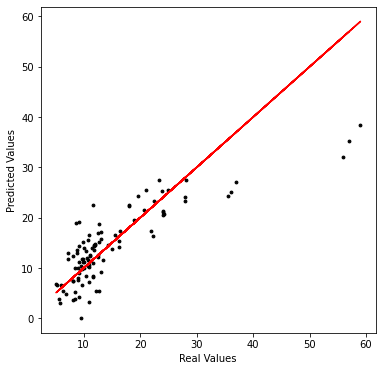

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(age_test, predicted_ages, color="black", s=8)
ax.plot(age_test, age_test, color="red")
ax.set_xlabel("Real Values")
_ = ax.set_ylabel("Predicted Values")

##### Test $R^2$

In [18]:
from sklearn.metrics import r2_score

r2_score(age_test, predicted_ages)

0.6864930356339689

##### Test MSE (Mean Squared Prediction Error)

In [19]:
from sklearn.metrics import mean_squared_error

mean_squared_error(age_test, predicted_ages)

30.810258013854284

#### Coefficients

To retrieve the chosen model's coefficients:

In [20]:
coefficients = linear_model_searcher.best_estimator_.coef_
coefficients

array([-0., -0.,  0., ..., -0., -0., -0.])

In [21]:
n_coefficients = len(coefficients)
n_selected_coefficients = (coefficients != 0).sum()
n_removed = n_coefficients - n_selected_coefficients

print(
    f"{n_selected_coefficients}/{n_coefficients} features selected ({n_removed} removed)"
)

170/1440 features selected (1270 removed)


The `GridSearchCV` class does not collect all of the coefficients estimated by the generated models. To be able to visualize these changes over our chosen range of regularization strength values ($\alpha$) we would have to manually fit these models and "collect" the coefficient values.

In [22]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(max_iter=1_000_000, cv=N_CROSS_VALIDATIONS)
lasso_coefficient_values = []

for alpha in ALPHAS:
    lasso_model.set_params(alphas=[alpha])
    lasso_model.fit(X_train, age_train)
    lasso_coefficient_values.append(lasso_model.coef_)

lasso_coefficient_values = np.array(lasso_coefficient_values)

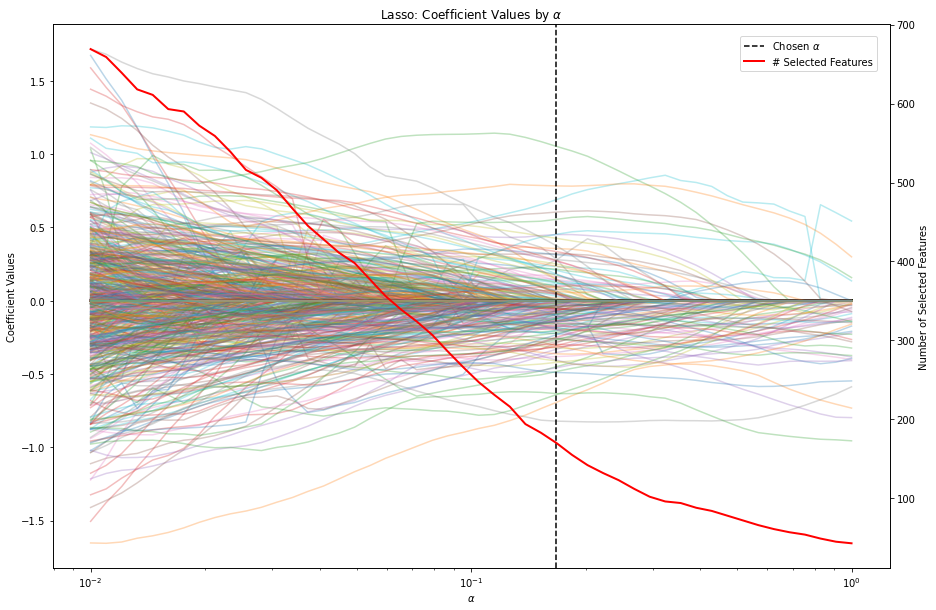

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title(r"Lasso: Coefficient Values by $\alpha$")

# Coefficient values by alpha
ax.semilogx(ALPHAS, lasso_coefficient_values, alpha=0.3)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Coefficient Values")

# Number of selected features
n_selected_features = (lasso_coefficient_values != 0).sum(axis=1)
n_features_ax = ax.twinx()
n_features_ax.semilogx(ALPHAS,
                       n_selected_features,
                       color="red",
                       linewidth=2,
                       label="# Selected Features")
n_features_ax.set_ylabel("Number of Selected Features")

# Chosen alpha
ax.axvline(best_alpha, linestyle="--", color="black", label=r"Chosen $\alpha$")

_ = fig.legend(loc="center", bbox_to_anchor=(0.825, 0.84))

Let's create a more convenient table to display the estimated coefficient values:

In [97]:
MEASUREMENT_DICT = {
    "fsArea": "Surface Area",
    "fsCT": "Cortical Thinkness",
    "fsVol": "Cortical Volume",
    "fsLGI": "Local Gyrification Index"
}
HEMISPHERE_DICT = {"L": "Left", "R": "Right"}
REGION_IDS = range(1, 181)
FEATURE_INDEX = pd.MultiIndex.from_product(
    [HEMISPHERE_DICT.values(), REGION_IDS,
     MEASUREMENT_DICT.values()],
    names=["Hemisphere", "Region ID", "Measurement"])
COLUMN_NAMES = ["Identifier", "Coefficient Value"]


def parse_coefficient_values(X: pd.DataFrame,
                             coefficients: np.ndarray) -> dict:
    feature_info = pd.DataFrame(index=FEATURE_INDEX, columns=COLUMN_NAMES)
    for i, column_name in enumerate(X.columns):
        measurement, hemisphere, identifier, _ = column_name.split("_")
        measurement = MEASUREMENT_DICT.get(measurement)
        hemisphere = HEMISPHERE_DICT.get(hemisphere)
        region_id = i % 180 + 1
        feature_info.loc[(hemisphere, region_id,
                          measurement), :] = identifier, coefficients[i]
    return feature_info


coefficient_values = parse_coefficient_values(X, coefficients)
coefficient_values[coefficient_values["Coefficient Value"] != 0]

Identifier Coefficient Value
Hemisphere Region ID Measurement                                          
Left       6         Cortical Thinkness               V4         0.0503397
           7         Cortical Thinkness               V8        -0.0290201
                     Cortical Volume                  V8        -0.0967879
           8         Surface Area                      4          0.284453
                     Local Gyrification Index          4          0.277543
...                                                  ...               ...
Right      172       Cortical Thinkness              TGv          0.783275
           173       Cortical Thinkness            MBelt           -0.6337
                     Cortical Volume               MBelt         -0.482922
           174       Cortical Thinkness            LBelt          0.273631
           176       Cortical Volume               STSva         -0.278176

[170 rows x 2 columns]

Now we can easily query our calculated coefficients. E.g. to display the features with the largest estimated coefficient values:

In [98]:
coefficient_values.sort_values("Coefficient Value", ascending=False)

Identifier Coefficient Value
Hemisphere Region ID Measurement                                          
Left       163       Cortical Thinkness              VVC           1.05286
Right      172       Cortical Thinkness              TGv          0.783275
Left       120       Local Gyrification Index          H          0.689395
           136       Cortical Thinkness             TE2p          0.604953
Right      103       Local Gyrification Index         52          0.555195
...                                                  ...               ...
Left       111       Cortical Thinkness              AVI         -0.489738
Right      173       Cortical Thinkness            MBelt           -0.6337
           63        Cortical Volume                 8BM         -0.640556
           52        Cortical Thinkness                2         -0.693283
           168       Cortical Thinkness               Ig         -0.821572

[1440 rows x 2 columns]

Or even better, visualize each measurement's coefficient values in their respective ROIs using [`nilearn`](https://nilearn.github.io/) and [`nibabel`](https://nipy.org/nibabel/):

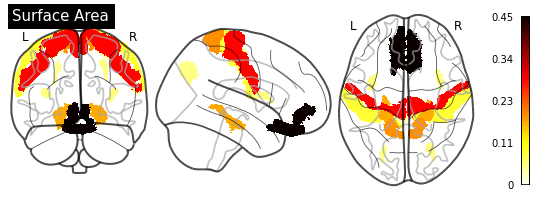

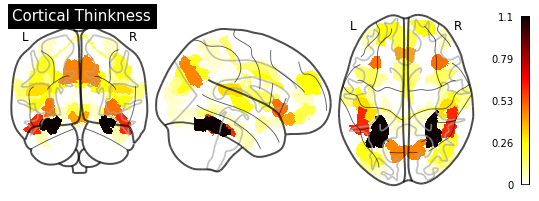

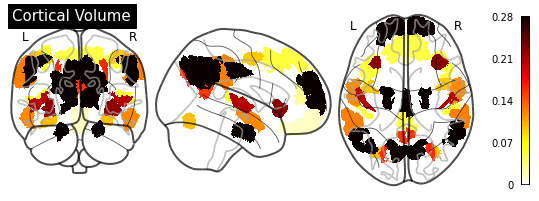

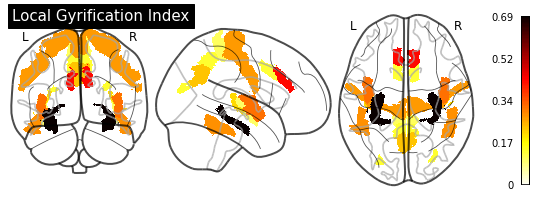

In [105]:
import nibabel as nib

from nilearn import datasets
from nilearn import plotting
from nilearn import surface
from nilearn.image import new_img_like

HCP_NIFTI_PATH = "HCP-MMP1_on_MNI152_ICBM2009a_nlin.nii.gz"
HCP_IMAGE = nib.load(HCP_NIFTI_PATH)
HCP_DATA = np.round(HCP_IMAGE.get_fdata())


def plot_coefficient_values(coefficient_values: pd.DataFrame,
                            measurement: str) -> None:
    """
    Plots coefficient estimation results using a "glass brain" plot.
    
    Parameters
    ----------
    coefficient_values : pd.DataFrame
        Formatted dataframe containing coefficient values indexed by
        (Hemisphere, Region ID, Measurement)
    measurement: str
        String identifier for the desired type of measurement
    """

    # Create a copy of the HCP-MMP1 atlas array
    template = HCP_DATA.copy()

    # Replace region indices in the template with their matching coefficient values
    for hemisphere in HEMISPHERE_DICT.values():
        # Query appropriate rows
        selection = coefficient_values.xs((hemisphere, measurement),
                                          level=("Hemisphere", "Measurement"))
        # Extract an array of coefficient values
        values = selection["Coefficient Value"].values
        # Replace region indices with values
        for region_id in REGION_IDS:
            template_id = region_id if hemisphere == "Left" else region_id + 180
            template[template == template_id] = values[region_id - 1]

    # Create a `nibabel.nifti1.Nifti1Image` instance for `plot_glass_brain`
    coefficients_nifti = new_img_like(HCP_IMAGE, template, HCP_IMAGE.affine)

    _ = plotting.plot_glass_brain(coefficients_nifti,
                                  display_mode='ortho',
                                  colorbar=True,
                                  title=measurement)


for measurement in MEASUREMENT_DICT.values():
    plot_coefficient_values(coefficient_values, measurement)

## Predicting ASD Diagnosis

We'll use `sklearn`'s [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to select a model predicting ASD diagnosis using the provided features.

`LogisticRegressionCV` implements an $\ell_2$ (i.e. "ridge") penalty by default and allows us to easily hypertune our model using a grid of regularization strength values.

### Model Creation

In [109]:
from sklearn.linear_model import LogisticRegressionCV

# The LogisticRegression class uses inverse regularization strength values
Cs = 1 / ALPHAS

logistic_model = LogisticRegressionCV(Cs=Cs,
                                      cv=N_CROSS_VALIDATIONS,
                                      scoring="roc_auc",
                                      max_iter=10_000,
                                      random_state=0)
_ = logistic_model.fit(X_train, asd_diagnosis_train)

### Model Application

In [110]:
predicted_asd_diagnosis = logistic_model.predict(X_test)

### Model Evaluation

To simply report the selected model's regularization strength and score:

In [130]:
selected_alpha = 1 / logistic_model.C_[0]
score = logistic_model.score(X_test, asd_diagnosis_test)

print("Selected regularization strength:".ljust(40), f"{selected_alpha:.4f}")
print(f"Score ({logistic_model.scoring}):".ljust(40), f"{score:.4f}")

Selected regularization strength:        0.7543
Score (roc_auc):                         0.6023


#### Confusion Matrix

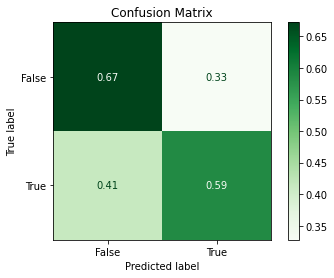

In [111]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(logistic_model,
                             X_test,
                             asd_diagnosis_test,
                             cmap=plt.cm.Greens,
                             normalize="true")
_ = disp.ax_.set_title(f"Confusion Matrix")

#### Classification Report

In [114]:
from sklearn.metrics import classification_report

report = classification_report(asd_diagnosis_test, predicted_asd_diagnosis)
print(report)

              precision    recall  f1-score   support

       False       0.67      0.67      0.67        58
        True       0.59      0.59      0.59        46

    accuracy                           0.63       104
   macro avg       0.63      0.63      0.63       104
weighted avg       0.63      0.63      0.63       104



#### ROC-AUC Curve

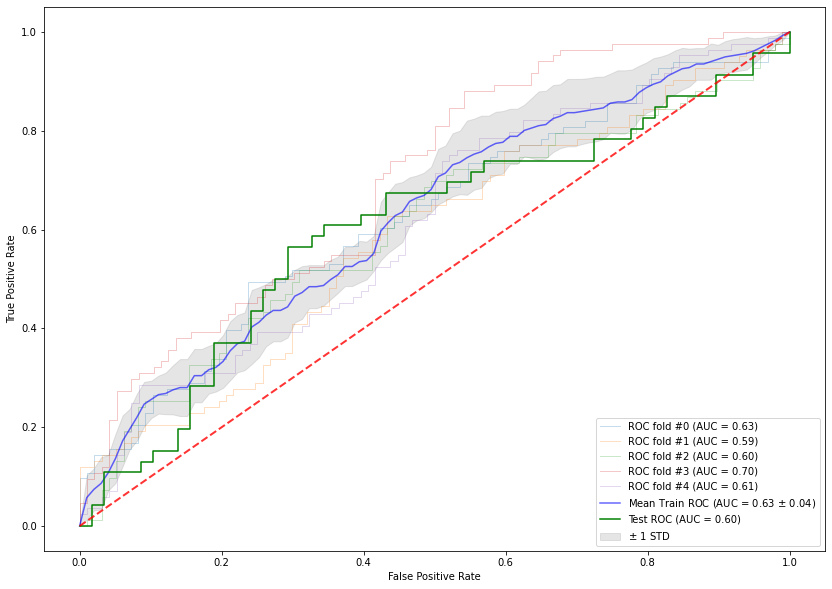

In [183]:
from sklearn.metrics import auc, plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

roc_auc_fig, roc_auc_ax = plt.subplots(figsize=(14, 10))
classifier = LogisticRegression(C=logistic_model.C_[0],
                                max_iter=10_000,
                                random_state=0)

true_positive_rates = []
auc_scores = []
mean_fpr = np.linspace(0, 1, 100)

cv = StratifiedKFold(n_splits=N_CROSS_VALIDATIONS,
                     shuffle=True,
                     random_state=0)
cv_splits = cv.split(X_train, asd_diagnosis_train)
for i, (train, test) in enumerate(cv_splits):
    classifier.fit(X_train.iloc[train], asd_diagnosis_train.iloc[train])
    curve_plot = plot_roc_curve(classifier,
                                X_train.iloc[test],
                                asd_diagnosis_train.iloc[test],
                                name=f"ROC fold #{i}",
                                alpha=0.25,
                                linewidth=1,
                                ax=roc_auc_ax)
    interp_tpr = np.interp(mean_fpr, curve_plot.fpr, curve_plot.tpr)
    interp_tpr[0] = 0.0
    true_positive_rates.append(interp_tpr)
    auc_scores.append(curve_plot.roc_auc)

mean_tpr = np.mean(true_positive_rates, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(auc_scores)
mean_roc_label = f"Mean Train ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})"
roc_auc_ax.plot(mean_fpr,
                mean_tpr,
                color="blue",
                label=mean_roc_label,
                alpha=0.6)

std_tpr = np.std(true_positive_rates, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
roc_auc_ax.fill_between(mean_fpr,
                        tprs_lower,
                        tprs_upper,
                        color='grey',
                        alpha=0.2,
                        label=r'$\pm$ 1 STD')

plot_roc_curve(logistic_model,
               X_test,
               asd_diagnosis_test,
               name="Test ROC",
               color="green",
               ax=roc_auc_ax)
_ = roc_auc_ax.plot([0, 1], [0, 1],
                linestyle='--',
                linewidth=2,
                color='red',
                label='Chance',
                alpha=0.8)

#### Coefficients

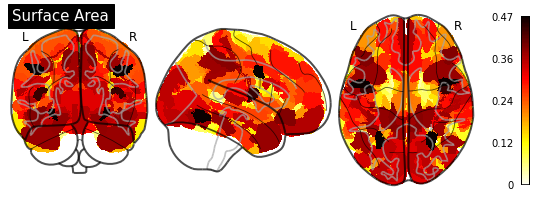

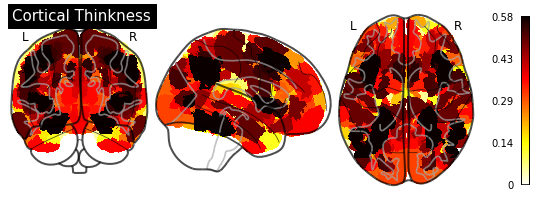

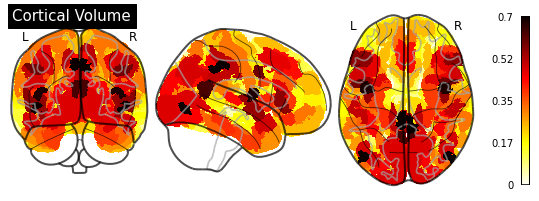

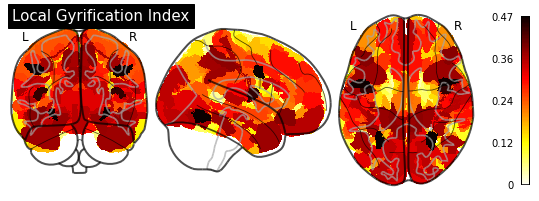

In [136]:
coefficient_values = parse_coefficient_values(X, logistic_model.coef_.ravel())
for measurement in MEASUREMENT_DICT.values():
    plot_coefficient_values(coefficient_values, measurement)